<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !git clone https://github.com/ManuelBagasina/DATCapstone.git

fatal: destination path 'DATCapstone' already exists and is not an empty directory.


In [3]:
!pip install tensorflow

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('/content/DATCapstone/data_preprocessed/df_preprocessed.csv', index_col='Date')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),Producer Price Index (PPI),...,reddit_Comment2_Sentiment_negative,reddit_Comment2_Sentiment_neutral,reddit_Comment2_Sentiment_positive,reddit_Comment3_Sentiment_negative,reddit_Comment3_Sentiment_neutral,reddit_Comment3_Sentiment_positive,Target_1day,Target_1week,Target_1month,Target_1year
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-30,140.983639,141.690227,138.647974,138.863876,89056700,0.0,0.0,23921.991,4.7,235.678,...,0.0,1.0,1.0,0.0,0.0,2.0,1.128616,1.756699,10.863815,9.008636
2021-10-01,139.256465,140.257467,136.518448,139.992493,94639600,0.0,0.0,24777.038,4.5,240.465,...,0.0,0.0,1.0,0.0,0.0,1.0,-3.444611,0.245361,7.016815,0.616699
2021-10-04,139.119068,139.560697,135.694095,136.547882,98322000,0.0,0.0,24777.038,4.5,240.465,...,0.0,0.0,0.0,0.0,0.0,0.0,1.933304,3.601608,9.637054,-0.162506
2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,240.465,...,0.0,0.0,0.0,0.0,0.0,0.0,0.873398,0.392517,8.744003,2.098389
2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,240.465,...,0.0,0.0,0.0,0.0,0.0,0.0,1.265991,-1.069672,9.313263,4.827072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,255.209412,257.926411,255.009620,257.916443,23234700,0.0,0.0,29700.580,4.1,253.590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.819061,NaN,NaN,NaN
2024-12-26,257.906429,259.814335,257.347047,258.735504,27237100,0.0,0.0,29700.580,4.1,253.590,...,0.0,0.0,0.0,0.0,0.0,0.0,-3.426208,NaN,NaN,NaN
2024-12-27,257.546826,258.415896,252.782075,255.309296,42355300,0.0,0.0,29700.580,4.1,253.590,...,0.0,0.0,0.0,0.0,0.0,0.0,-3.386276,NaN,NaN,NaN


In [7]:
df_1day = df.drop(['Target_1week', 'Target_1month', 'Target_1year'], axis=1)
df_1day.dropna(inplace = True)

df_1week = df.drop(['Target_1day', 'Target_1month', 'Target_1year'], axis=1)
df_1week.dropna(inplace = True)

df_1month = df.drop(['Target_1week', 'Target_1day', 'Target_1year'], axis=1)
df_1month.dropna(inplace = True)

df_1year = df.drop(['Target_1week', 'Target_1month', 'Target_1day'], axis=1)
df_1year.dropna(inplace = True)

In [97]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def lstm(data):
  df = df_1day.drop(columns='Target_1day')

  # Feature Engineering
  df['Close_lag1'] = df['Close'].shift(1)
  df['Close_lag3'] = df['Close'].shift(3)
  df['Close_lag7'] = df['Close'].shift(7)
  df['Close_lag14'] = df['Close'].shift(14)
  df['Close_lag30'] = df['Close'].shift(30)
  df['Close_rolling_mean_3'] = df['Close'].rolling(window=3).mean()
  df['Close_rolling_mean_7'] = df['Close'].rolling(window=7).mean()

  df.dropna(inplace=True)
  df

  features = df.columns.tolist()
  target_col = 'Close'
  target_index = features.index(target_col)

  # Normalization
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(df)

  # Sequences generation
  def create_sequences(data, target_index, seq_len):
      X, y = [], []
      for i in range(seq_len, len(data) - 1):  # 다음날 종가 예측
          X.append(data[i - seq_len:i])
          y.append(data[i + 1, target_index])
      return np.array(X), np.array(y)

  seq_length = 30
  X, y = create_sequences(scaled, target_index, seq_length)

  # Split
  train_size = int(len(X) * 0.7)
  val_size = int(len(X) * 0.15)

  X_train = X[:train_size]
  y_train = y[:train_size]

  X_val = X[train_size:train_size + val_size]
  y_val = y[train_size:train_size + val_size]

  X_test = X[train_size + val_size:]
  y_test = y[train_size + val_size:]

  # LSTM model
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
  model.add(LSTM(64))
  model.add(Dropout(0.2))
  model.add(Dense(128))
  model.add(Dense(64))
  model.add(Dense(1))

  model.compile(optimizer='adam', loss='mean_squared_error')

  # EarlyStopping
  early_stop = EarlyStopping(
      monitor='val_loss',
      patience=5,
      restore_best_weights=True
  )

  # 8. Model Training
  history = model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      epochs=50,
      batch_size=16,
      callbacks=[early_stop],
      verbose=1
  )

  # Prediction
  pred = model.predict(X_test)

  # inverse rescale
  def inverse_rescale(pred, y_true, scaler, target_index):
      dummy_pred = np.zeros((len(pred), len(features)))
      dummy_pred[:, target_index] = pred[:, 0]
      pred_real = scaler.inverse_transform(dummy_pred)[:, target_index]

      dummy_actual = np.zeros((len(y_true), len(features)))
      dummy_actual[:, target_index] = y_true
      actual_real = scaler.inverse_transform(dummy_actual)[:, target_index]

      return pred_real, actual_real

  predicted_price, actual_price = inverse_rescale(pred, y_test, scaler, target_index)

  # Visualization
  plt.figure(figsize=(12,6))
  plt.plot(actual_price, label='Actual Close Price')
  plt.plot(predicted_price, label='Predicted Close Price')
  plt.title('Next-Day Close Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Price')
  plt.legend()
  plt.show()

  print("MSE:", mean_squared_error(actual_price, predicted_price))
  print("MAE:", mean_absolute_error(actual_price, predicted_price))

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 61s 143ms/step - loss: 0.1193 - val_loss: 0.0199
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 0.0140 - val_loss: 0.0171
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0.0110 - val_loss: 0.0297
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0078 - val_loss: 0.0148
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0106 - val_loss: 0.0148
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0076 - val_loss: 0.0141
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.0084 - val_loss: 0.0154
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 0.0047 - val_loss: 0.0148
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0038 - val_loss: 0.0141
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0044 - val_loss: 0.0142
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.0043 - val_loss: 0.0136
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/st

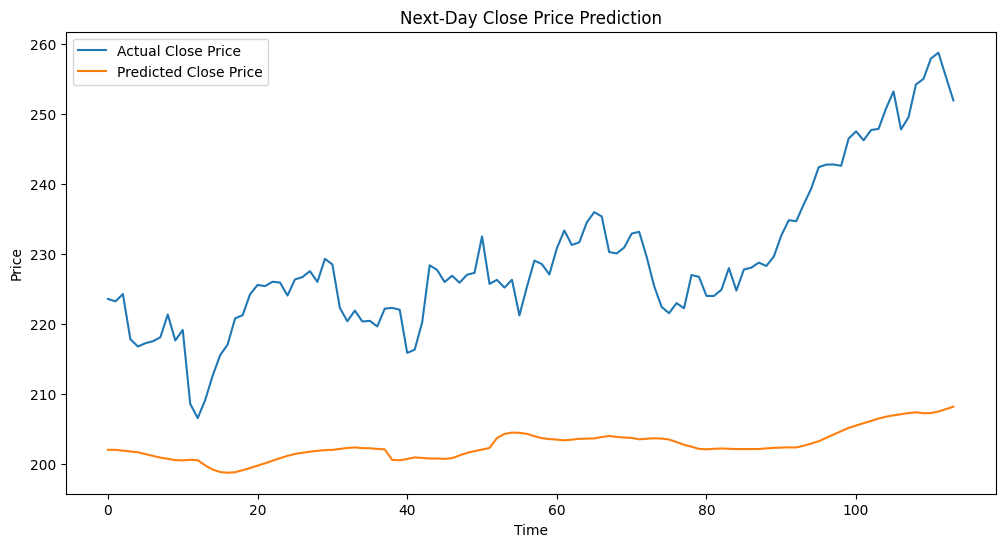

MSE: 782.553857206459
MAE: 26.425384998651396


In [98]:
lstm(df_1week)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - loss: 0.0608 - val_loss: 0.0186
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0155 - val_loss: 0.0193
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - loss: 0.0117 - val_loss: 0.0170
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0077 - val_loss: 0.0146
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.0092 - val_loss: 0.0199
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0051 - val_loss: 0.0149
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0064 - val_loss: 0.0161
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.0045 - val_loss: 0.0140
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0046 - val_loss: 0.0148
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0044 - val_loss: 0.0148
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - loss: 0.0038 - val_loss: 0.0151
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step 

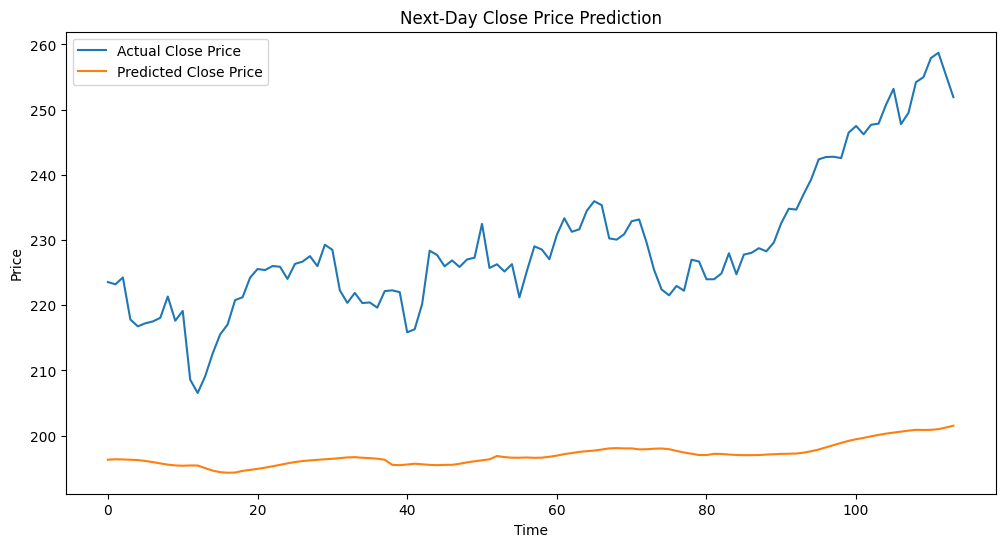

MSE: 1117.7940271717296
MAE: 32.0658020779259


In [99]:
lstm(df_1month)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - loss: 0.1199 - val_loss: 0.0367
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0141 - val_loss: 0.0190
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0112 - val_loss: 0.0198
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.0091 - val_loss: 0.0167
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.0078 - val_loss: 0.0149
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.0085 - val_loss: 0.0155
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0048 - val_loss: 0.0143
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0051 - val_loss: 0.0140
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - loss: 0.0042 - val_loss: 0.0134
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0053 - val_loss: 0.0160
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0055 - val_loss: 0.0144
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step -

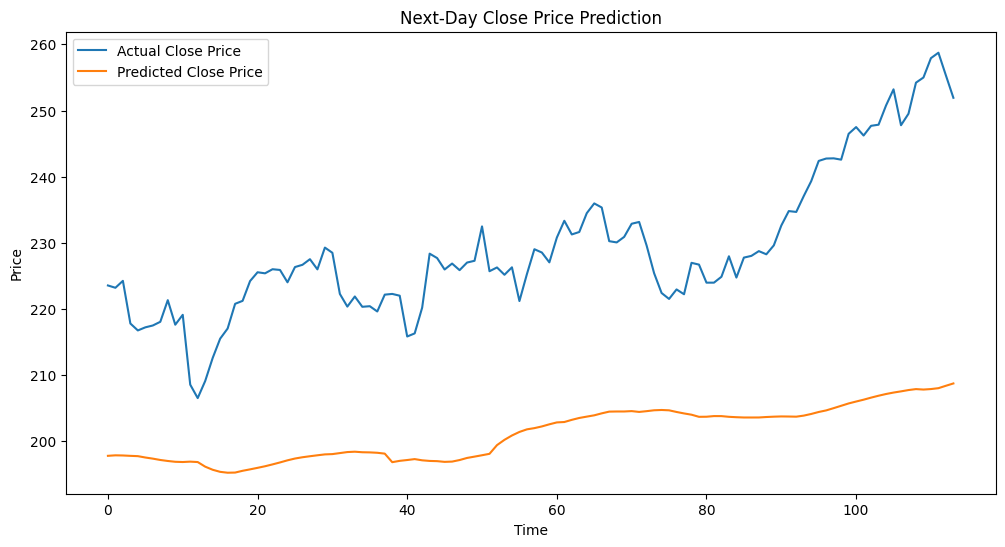

MSE: 846.5884715174197
MAE: 27.9418219577959


In [100]:
lstm(df_1year)